In [1]:
#**** Sentiment Analysis using Dutch Tweets****
# by SELIM SAMETOGLU
# 14-Apr-2023 - started writing this code
# Between 14 and 18 Apr-2023 a running version was succesfully made.
# 18-Apr-2023- added a function using chatgpt to filter out the non-Dutch sentences



In [2]:
# to connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load the dependencies
# Utility
import pandas as pd
import numpy as np
import re
# Prepro
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
data = pd.read_json("/content/drive/MyDrive/Collab_data/dutch_tweets_chunk0.json")

In [7]:
data.head()

,full_text,text_translation,created_at,screen_name,description,desc_translation,weekofyear,weekday,day,month,...,point,latitude,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",@pflegearzt @Friedelkorn @ LAguja44 Pardon wol...,2020-03-09 12:26:29,TheoRettich,"I ❤️science, therefore a Commie. ☭ FALGSC: P...","I ❤️science, Therefore a Commie. ☭ FALGSC: Par...",11,0,9,3,...,"(52.5001698, 5.7480821, 0.0)",52.50017,5.748082,0.0,Flevoland,None,None,False,0.0,0.0
1,RT @grantshapps: Aviation demand is reduced du...,RT @grantshapps: Aviation demand is reduced du...,2020-03-09 12:26:34,davidiwanow,I tweet a lot but love to engage & converse. P...,I tweet a lot but love to engage and converse....,11,0,9,3,...,"(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.0
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.0
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.0
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,2020-03-09 12:26:47,EhrErwin,Budget-Life Coach. Time management Coaching. b...,Budget-Life Coach. Time management coaching. h...,11,0,9,3,...,"(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.0


In [8]:
print('number of messages:', len(data))

number of messages: 27019


array([[<Axes: title={'center': 'sentiment_pattern'}>]], dtype=object)

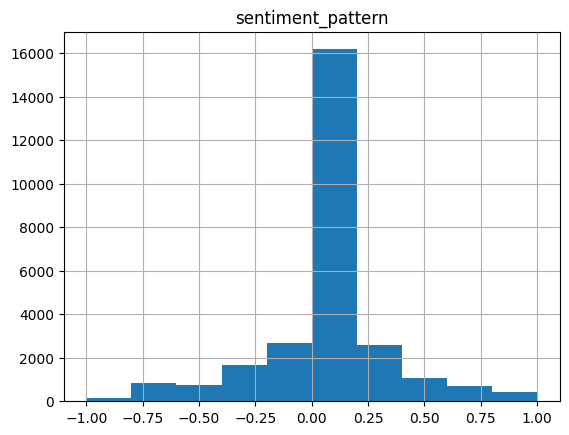

In [9]:
data[["sentiment_pattern"]].hist()

In [ ]:
### data[["sentiment_pattern"]]

array([[<Axes: title={'center': 'sentiment_pattern'}>]], dtype=object)

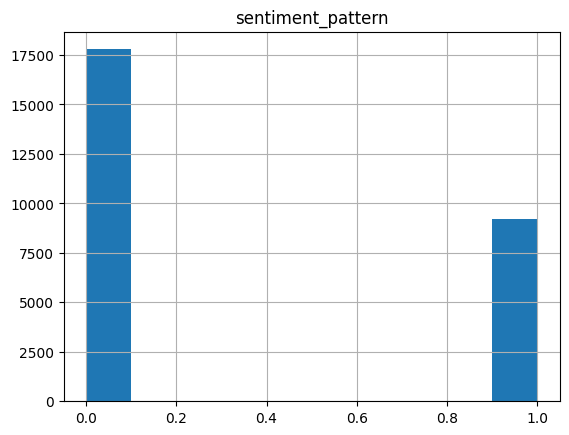

In [10]:
data.loc[data["sentiment_pattern"] <0, "sentiment_pattern"] = 0
data.loc[data["sentiment_pattern"] >0, "sentiment_pattern"] = 1
data[["sentiment_pattern"]].hist()


In [ ]:
# filter out non-Dutch sentences
import pandas as pd
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

data['language']=data['full_text'].apply(detect_language)

data = data[data['language'] == 'nl']

data_lang_filtered = data.drop('language', axis = 1, inplace = True)



In [ ]:
data = data[["full_text", "sentiment_pattern"]]

In [ ]:
len(data)

20899

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)

In [ ]:
# checking null values
np.sum(data.isnull().any(axis=1))

0

In [ ]:
data.columns = ["text", "label"]

In [ ]:
# make the statement text in lowercase
data['text']=data['text'].str.lower()

In [ ]:
data['text'].tail()

27011    lap corona in de ruimte! @jdceulaer is nog wel...
27012    beantwoording kamervragen over het verband tus...
27013    rt @detomhelsen: mijn vrouw is slimmer dan ik....
27014    @jochemmyjer als je hooikoorts hebt spuug je v...
27015    @jochemmyjer als je hooikoorts hebt spuug je v...
Name: text, dtype: object

In [ ]:
# define the DUTCH stopwordlist
stopwordlist = ['aan',
'al',
'alles',
'als',
'altijd',
'andere',
'ben',
'bij',
'daar',
'dan',
'dat',
'de',
'der',
'deze',
'die',
'dit',
'doch',
'doen',
'door',
'dus',
'een',
'eens',
'en',
'er',
'ge',
'geen',
'geweest',
'haar',
'had',
'heb',
'hebben',
'heeft',
'hem',
'het',
'hier',
'hij',
'hoe',
'hun',
'iemand',
'iets',
'ik',
'in',
'is',
'ja',
'je',
'kan',
'kon',
'kunnen',
'maar',
'me',
'meer',
'men',
'met',
'mij',
'mijn',
'moet',
'na',
'naar',
'niet',
'niets',
'nog',
'nu',
'of',
'om',
'omdat',
'onder',
'ons',
'ook',
'op',
'over',
'reeds',
'te',
'tegen',
'toch',
'toen',
'tot',
'u',
'uit',
'uw',
'van',
'veel',
'voor',
'want',
'waren',
'was',
'wat',
'werd',
'wezen',
'wie',
'wil',
'worden',
'wordt',
'zal',
'ze',
'zelf',
'zich',
'zij',
'zijn',
'zo',
'zonder',
'zou']


In [ ]:
# clean and remove the stopwords from the text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

2    rt @ddstandaard: droom d66 werkelijkheid: covi...
3    rt @ddstandaard: droom d66 werkelijkheid: covi...
4    droom d66 werkelijkheid: covid-19 superdodelij...
5    droom d66 werkelijkheid: covid-19 superdodelij...
9    rt @frankvanwijck: aantal deskundigen corona g...
Name: text, dtype: object

In [ ]:
# clean and remove the punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

27011    lap corona ruimte jdceulaer wel ff zoet httpst...
27012    beantwoording kamervragen verband tussen lucht...
27013    rt detomhelsen vrouw slimmer ik lockdown ni se...
27014    jochemmyjer hooikoorts hebt spuug verder ooit ...
27015    jochemmyjer hooikoorts hebt spuug verder ooit ...
Name: text, dtype: object

In [ ]:
# clean and remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

27011    lap corona ruimte jdceulaer wel ff zoet httpst...
27012    beantwoording kamervragen verband tussen lucht...
27013    rt detomhelsen vrouw slimmer ik lockdown ni se...
27014    jochemmyjer hooikoorts hebt spuug verder ooit ...
27015    jochemmyjer hooikoorts hebt spuug verder ooit ...
Name: text, dtype: object

In [ ]:
# clean and remove URLs
def cleaning_URLs(dataset):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

27011    lap corona ruimte jdceulaer wel ff zoet httpst...
27012    beantwoording kamervragen verband tussen lucht...
27013    rt detomhelsen vrouw slimmer ik lockdown ni se...
27014    jochemmyjer hooikoorts hebt spuug verder ooit ...
27015    jochemmyjer hooikoorts hebt spuug verder ooit ...
Name: text, dtype: object

In [ ]:
# clean and remove numbers
def cleaning_numbers(dataset):
    return re.sub('[0-9]+', '', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

27011    lap corona ruimte jdceulaer wel ff zoet httpst...
27012    beantwoording kamervragen verband tussen lucht...
27013    rt detomhelsen vrouw slimmer ik lockdown ni se...
27014    jochemmyjer hooikoorts hebt spuug verder ooit ...
27015    jochemmyjer hooikoorts hebt spuug verder ooit ...
Name: text, dtype: object

In [ ]:
data['text']

2        rt ddstandaard droom d werkelijkheid covi supe...
3        rt ddstandaard droom d werkelijkheid covi supe...
4        droom d werkelijkheid covi superdodelijk ouder...
5        droom d werkelijkheid covi superdodelijk ouder...
9        rt frankvanwijck aantal deskundigen corona gri...
                               ...                        
27011    lap corona ruimte jdceulaer wel ff zoet httpst...
27012    beantwoording kamervragen verband tussen lucht...
27013    rt detomhelsen vrouw slimmer ik lockdown ni se...
27014    jochemmyjer hooikoorts hebt spuug verder ooit ...
27015    jochemmyjer hooikoorts hebt spuug verder ooit ...
Name: text, Length: 20899, dtype: object

In [ ]:
# tokenization
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text']

2        [rt, ddstandaard, droom, d, werkelijkheid, cov...
3        [rt, ddstandaard, droom, d, werkelijkheid, cov...
4        [droom, d, werkelijkheid, covi, superdodelijk,...
5        [droom, d, werkelijkheid, covi, superdodelijk,...
9        [rt, frankvanwijck, aantal, deskundigen, coron...
                               ...                        
27011    [lap, corona, ruimte, jdceulaer, wel, ff, zoet...
27012    [beantwoording, kamervragen, verband, tussen, ...
27013    [rt, detomhelsen, vrouw, slimmer, ik, lockdown...
27014    [jochemmyjer, hooikoorts, hebt, spuug, verder,...
27015    [jochemmyjer, hooikoorts, hebt, spuug, verder,...
Name: text, Length: 20899, dtype: object

In [ ]:
# stemming
from nltk.stem.snowball import DutchStemmer

st = DutchStemmer()
def stemming_on_text(dataset):
    text = [st.stem(word) for word in dataset]
    return dataset
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

2    [rt, ddstandaard, droom, d, werkelijkheid, cov...
3    [rt, ddstandaard, droom, d, werkelijkheid, cov...
4    [droom, d, werkelijkheid, covi, superdodelijk,...
5    [droom, d, werkelijkheid, covi, superdodelijk,...
9    [rt, frankvanwijck, aantal, deskundigen, coron...
Name: text, dtype: object

In [ ]:
# create the 'X' with the features, and create the'y' with the annotations/sentiment
X = data['text']
y = data['label']

In [ ]:
data_pos = data.loc[data['label'] == 1]
data_neg = data.loc[data['label'] == 0]
data_pos = data_pos['text']
data_neg = data_neg['text']

In [ ]:
data_pos.info, data_neg.info

(<bound method Series.info of 9        [rt, frankvanwijck, aantal, deskundigen, coron...
 10       [rt, frankvanwijck, aantal, deskundigen, coron...
 11       [rt, hantenbroeke, benieuwd, coronavirus, onde...
 14       [komt, coronavirus, helaas, steeds, dichterbij...
 22       [🤣🤣🤣, volksgezondheid, shell, nam, unilever, e...
                                ...                        
 27007    [korting, €, belastingtarief, zestien, product...
 27008    [korting, €, belastingtarief, zestien, product...
 27011    [lap, corona, ruimte, jdceulaer, wel, ff, zoet...
 27014    [jochemmyjer, hooikoorts, hebt, spuug, verder,...
 27015    [jochemmyjer, hooikoorts, hebt, spuug, verder,...
 Name: text, Length: 8445, dtype: object>,
 <bound method Series.info of 2        [rt, ddstandaard, droom, d, werkelijkheid, cov...
 3        [rt, ddstandaard, droom, d, werkelijkheid, cov...
 4        [droom, d, werkelijkheid, covi, superdodelijk,...
 5        [droom, d, werkelijkheid, covi, superdodelijk,...

/tmp/ipykernel_215497/1498882562.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data_neg = data_neg[:9230]


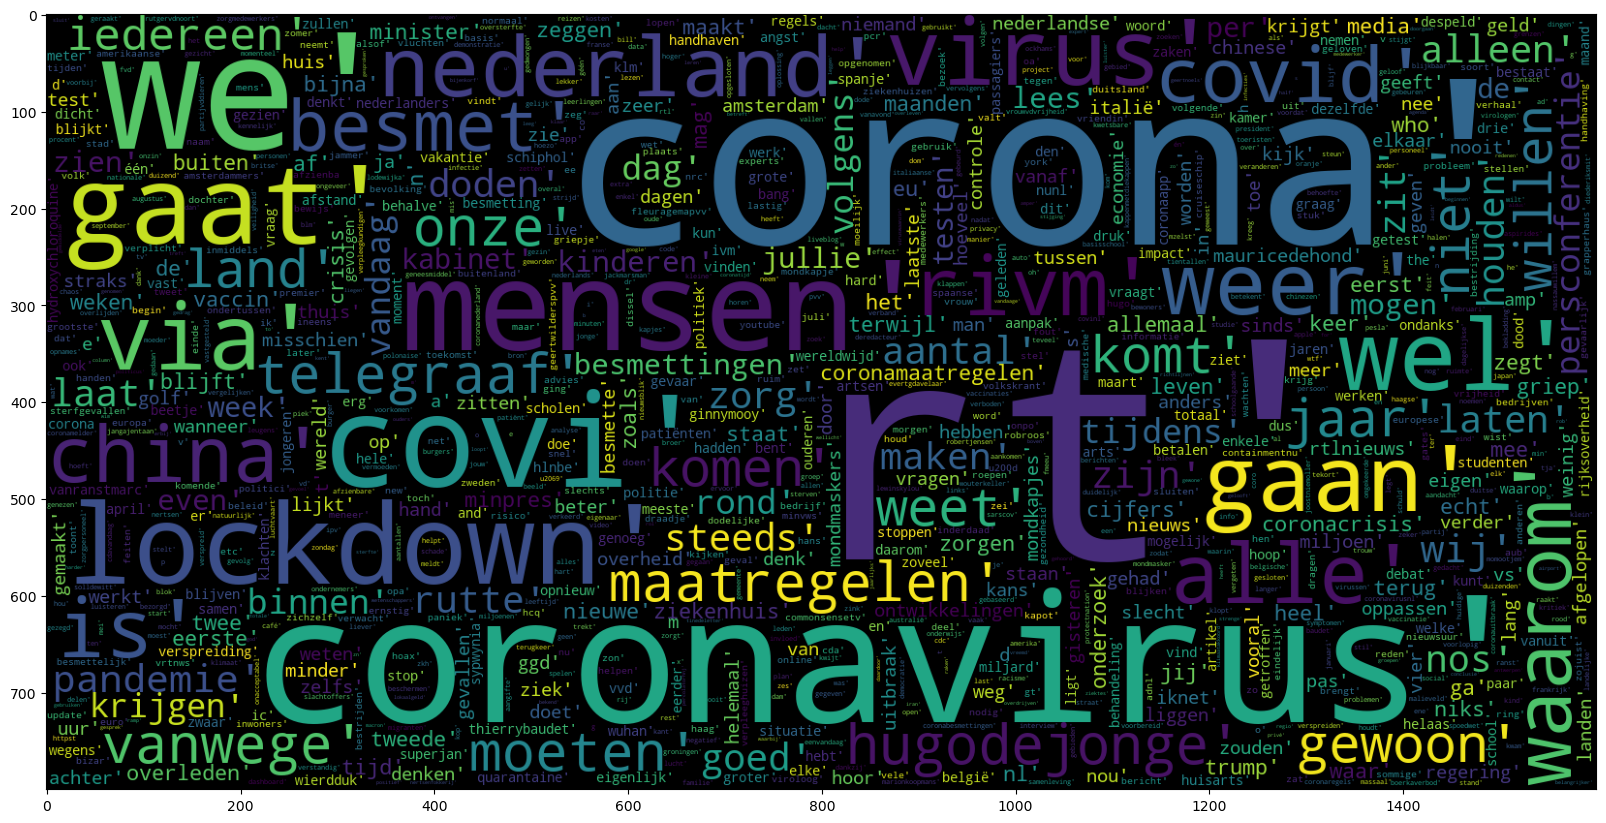

In [ ]:
data_neg = data_neg[:9230]
plt.figure(figsize = (20,20))
wc_neg = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_neg)))
plt.imshow(wc_neg)


/tmp/ipykernel_215497/1154701459.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data_pos = data_pos[:17789]


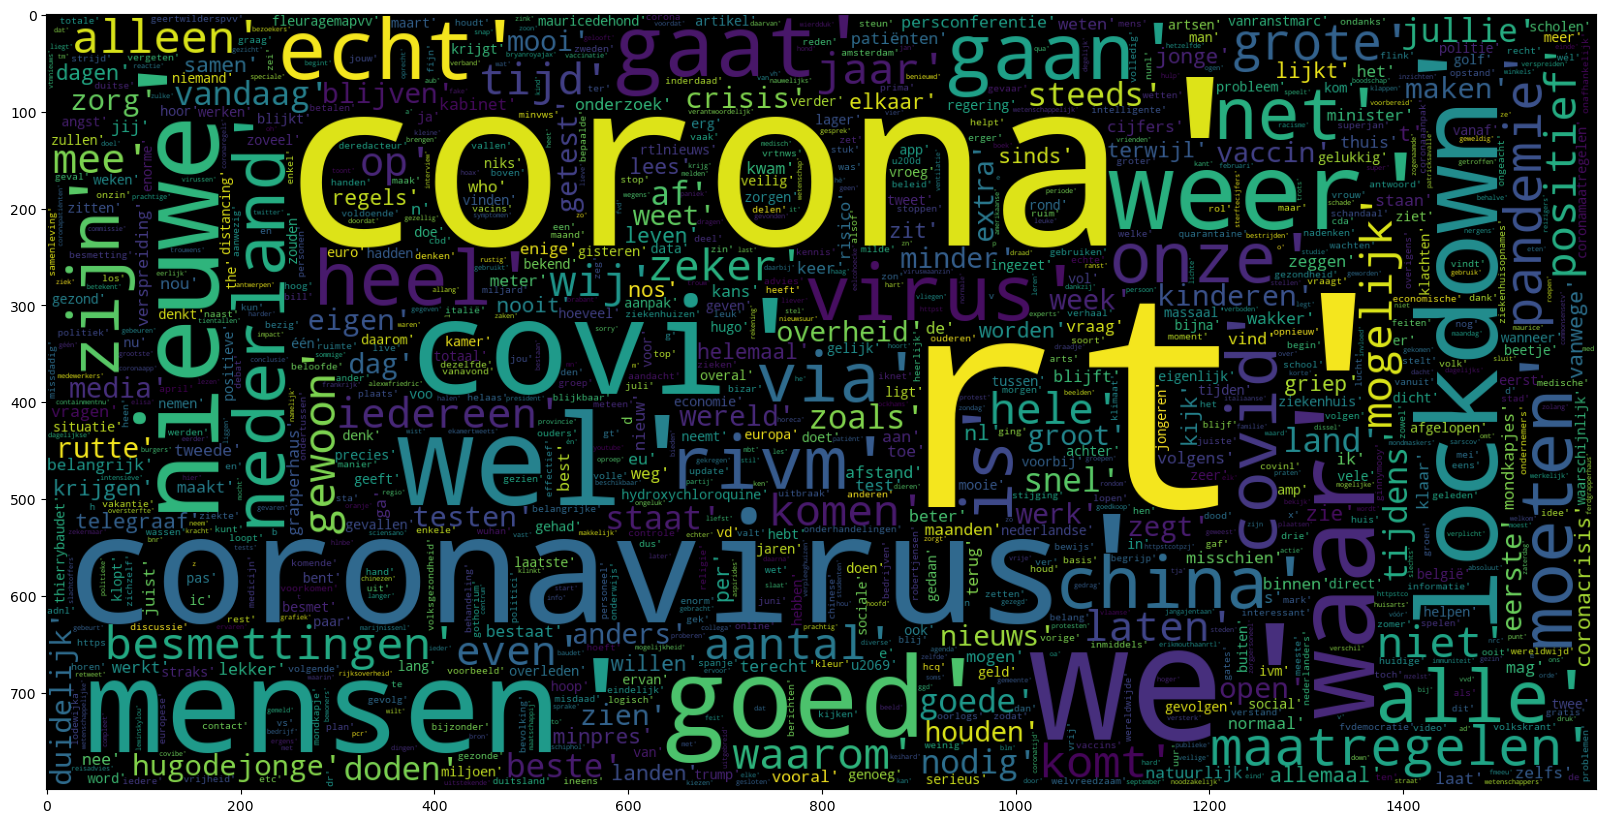

In [ ]:
data_pos = data_pos[:17789]
plt.figure(figsize = (20,20))
wc_pos = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_pos)))
plt.imshow(wc_pos)


In [ ]:
# split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [ ]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

In [ ]:
# FIT THE TF-IDF VECTORIZER BASED ON THE TRAIN DATA
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features = 500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  170023


In [ ]:
# TRANSFORM THE DATA USING TF-IDF VECTORIZER; TRANSFORM BOTH TRAIN AND THE TEST DATA
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [ ]:
# NICE WRAPPED UP MODEL EVALUATION FUNCTION. REAUSABLE.
# creds to https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89       611
         1.0       0.99      0.67      0.80       434

    accuracy                           0.86      1045
   macro avg       0.90      0.83      0.85      1045
weighted avg       0.88      0.86      0.85      1045



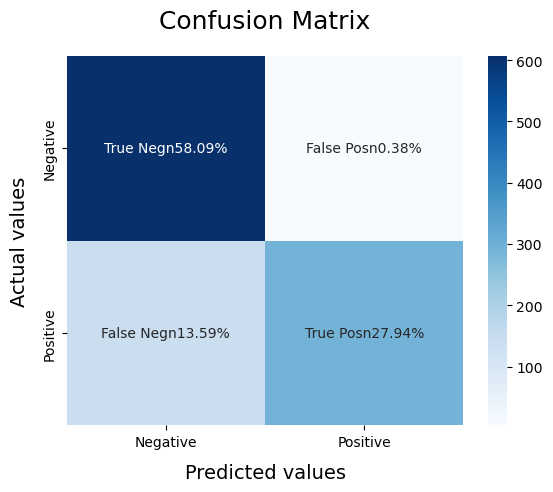

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

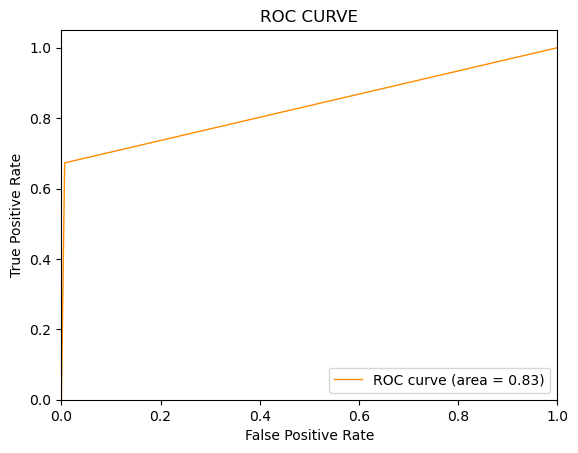

In [ ]:
# SAME AS ABOVE, NICE WRAPPER, this time for the ROC CURVE:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       611
         1.0       0.91      0.90      0.90       434

    accuracy                           0.92      1045
   macro avg       0.92      0.92      0.92      1045
weighted avg       0.92      0.92      0.92      1045



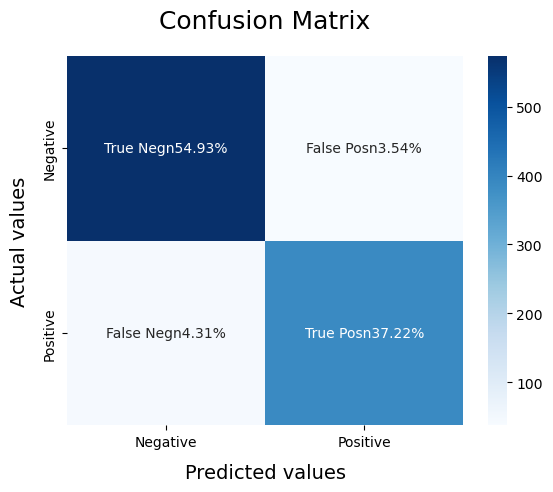

In [ ]:
# MODEL - 2
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

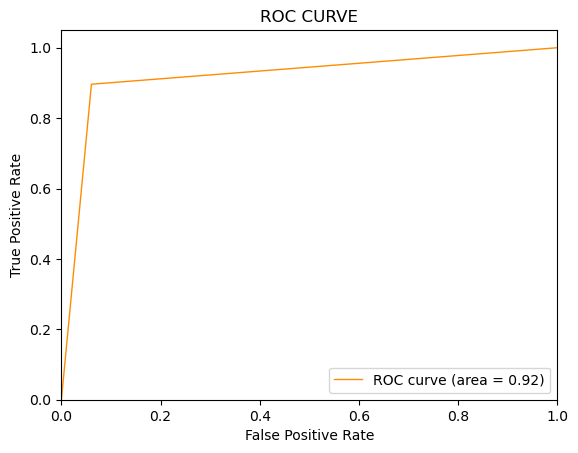

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       611
         1.0       0.93      0.86      0.89       434

    accuracy                           0.91      1045
   macro avg       0.92      0.91      0.91      1045
weighted avg       0.92      0.91      0.91      1045



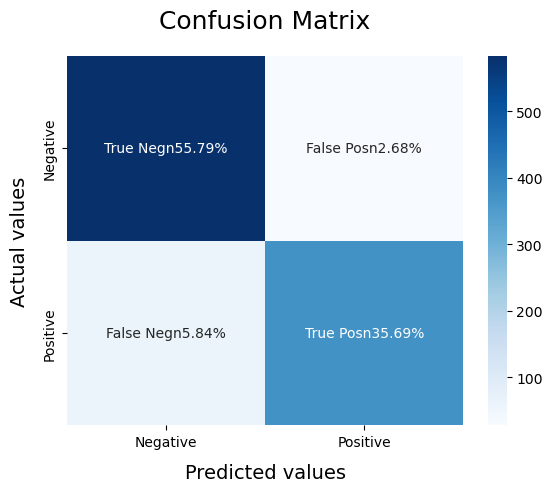

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

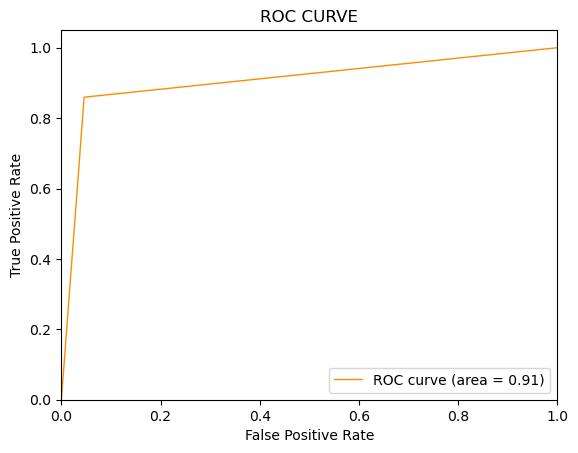

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# result: linear support vector classifier (svc) worked the best
